<a href="https://colab.research.google.com/github/Usamaahmad06/Avalanche-an-end-to-end-library-for-continual-learning/blob/main/CIFAR100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install avalanche-lib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 971.9/971.9 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.4/532.4 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.

100%|██████████| 169001437/169001437 [00:03<00:00, 47694292.60it/s]


Extracting /root/.avalanche/data/cifar100/cifar-100-python.tar.gz to /root/.avalanche/data/cifar100
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/avalanche/training/templates/base.py:468: PositionalArgumentsDeprecatedWarning: Avalanche is transitioning to strategy constructors that accept named (keyword) arguments only. This is done to ensure that there is no confusion regarding the meaning of each argument (strategies can have many arguments). Your are passing 3 positional arguments to the Naive.__init__ method. Consider passing them as names arguments. The ability to pass positional arguments will be removed in the future.
  warnings.warn(error_str, category=PositionalArgumentsDeprecatedWarning)
/usr/local/lib/python3.10/dist-packages/avalanche/training/templates/base.py:468: PositionalArgumentsDeprecatedWarning: Avalanche is transitioning to strategy constructors that accept named (keyword) arguments only. This is done to ensure that there is no confusion regarding the meaning of each argument (strategies can have many arguments). Your are passing 3 positional arguments to the Replay.__

Running Naive strategy
-- >> Start of training phase << --
100%|██████████| 313/313 [00:12<00:00, 25.94it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.2043
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.3125
100%|██████████| 313/313 [00:11<00:00, 26.30it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.2640
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.3750
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 63/63 [00:01<00:00, 44.75it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.2805
-- Starting eval on experience 1 (Task 0) from test stream --
100%|██████████| 63/63 [00:01<00:00, 44.40it/s]
> Eval on experience 1 (Task 0) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp001 = 0.0000
-- Starting eval on experience 2 (Task 0) from test stream --
100

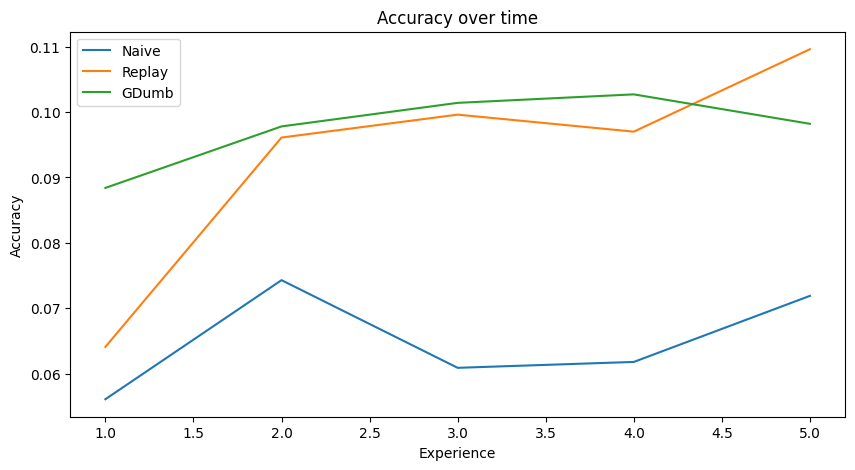

In [2]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torchvision import transforms
from avalanche.benchmarks.classic import SplitCIFAR100
from avalanche.evaluation.metrics import accuracy_metrics
from avalanche.logging import InteractiveLogger, TextLogger
from avalanche.training.plugins import EvaluationPlugin
from avalanche.training.supervised import Naive, Replay, GDumb
import matplotlib.pyplot as plt

# Load CIFAR-100 dataset with Avalanche
scenario = SplitCIFAR100(n_experiences=5, seed=1, return_task_id=False)

# Model definition
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(32 * 32 * 3, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 100)
)

# Loss function and optimizer
criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01)

# Evaluation plugin
interactive_logger = InteractiveLogger()
text_logger = TextLogger(open('log.txt', 'w'))
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loggers=[interactive_logger, text_logger]
)

# Strategies
strategies = {
    'Naive': Naive(model, optimizer, criterion, train_mb_size=32, train_epochs=2, eval_mb_size=32, evaluator=eval_plugin),
    'Replay': Replay(model, optimizer, criterion, train_mb_size=32, train_epochs=2, eval_mb_size=32, evaluator=eval_plugin, mem_size=200),
    'GDumb': GDumb(model, optimizer, criterion, train_mb_size=32, train_epochs=2, eval_mb_size=32, evaluator=eval_plugin, mem_size=200)
}

# Run strategies and collect results
results = {}
for strategy_name, strategy in strategies.items():
    print(f'Running {strategy_name} strategy')
    results[strategy_name] = []
    for experience in scenario.train_stream:
        strategy.train(experience)
        eval_results = strategy.eval(scenario.test_stream)
        acc = eval_results['Top1_Acc_Stream/eval_phase/test_stream/Task000']
        results[strategy_name].append(acc)

# Plotting results
plt.figure(figsize=(10, 5))
for strategy_name, accuracies in results.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=strategy_name)
plt.xlabel('Experience')
plt.ylabel('Accuracy')
plt.title('Accuracy over time')
plt.legend()
plt.show()